# Impute missing data using seasonal decomposition and interpolation.

This notebook shows how we can use interpolation methods along with seasonal decomposition to fill missing data for a time series.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')

# Load dataset

In [2]:
df = pd.read_csv('../Datasets/example_retail_sales_with_missing_data.csv', parse_dates=['ds'], index_col=['ds'])

In [3]:
df.head()

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


# Check for missing data

We check for missing data in the target and quantify how many missing values there are.

In [4]:
n_missing = df['y'].isnull().sum()

print(f"Number of datapoints missing: {n_missing}")
print(f"Proportion of dataset missing: {n_missing/len(df):.2%}")

Number of datapoints missing: 33
Proportion of dataset missing: 20.62%


We plot the time series to see where the data is missing.

<AxesSubplot:xlabel='ds'>

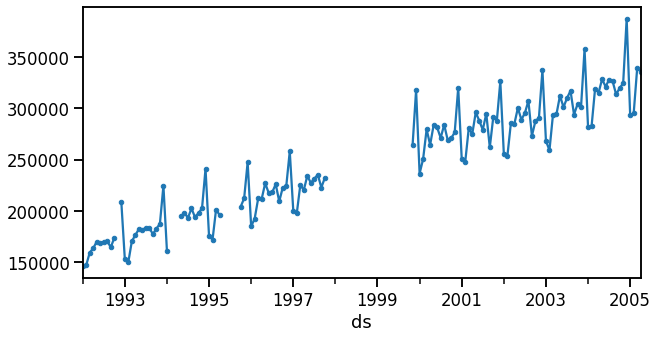

In [5]:
df.plot(marker='.', figsize=[10, 5], legend=None)


# Seasonal-Trend decomposition using LOESS (STL)


This method involves estimating the seasonal component of a time series. This is then subtracted from the original time series to provide a de-seasoned time series. Any of the prior interpolation methods can then be used on the de-seasoned time series and the seasonal component can be added back to the de-seasoned time series. 

There are many different methods to decompose a time series into seasonal and other components. We shall use STL for this notebook.

In this section we show how to use the STL method to extract the seasonal component of a time series. An advantage of STL is that it is able to estimate a seasonal component which can change over time (e.g., if the amplitude or frequency of the seasonal component changes).

The details of the method can be found in the [original paper](http://www.nniiem.ru/file/news/2016/stl-statistical-model.pdf)

In [6]:
from statsmodels.tsa.seasonal import STL

STL can't handle missing data. A linear interpolation is typically used to fill missing data before decomposing the time series using STL. 

In [7]:
# Apply STL decomposition 
res = STL(df.interpolate(method='linear'), seasonal=31).fit()

The seasonal parameter determines how much data is used to infer the seasonality at any given point. If the seasonal component is thought to be fixed throughout time then a large seasonal parameter can be set so that more data is used to determine the seasonal component. Likewise if the seasonal component is thought to change (e.g., the frequency) quickly over time the seasonal parameter can be reduced so that only recent data contributes to determining the seasonal component. 

The large missing gap is linearly interpolated. This means that the algorithm sees a region of data with no seasonal component and could distort the estimation of the seasonal component. A large seasonal parameter is set to overcome this. This works because a larger portion of the data is now used to estimate the seasonal component meaning that the local distortion from the interpolation has less effect.

We now plot the decomposition to inspect that it is reasonable.

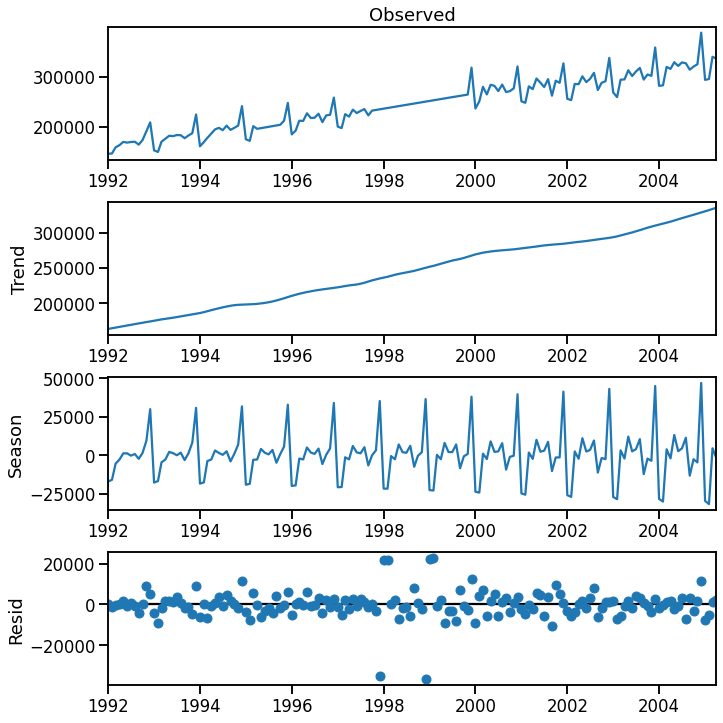

In [8]:
plt.rc('figure',figsize=(10,10))
plt.rc('font',size=5)
res.plot();

We now:

1. extract the seasonal component
2. de-seasonalise the original time series
3. perform linear interpolation on the de-seasonalised data
4. Add the seasonal component back to the imputed de-seasonalised data

In [9]:
# Extract seasonal component
seasonal_component = res.seasonal
seasonal_component.head()

ds
1992-01-01   -17093.246676
1992-02-01   -15953.208314
1992-03-01    -5465.127087
1992-04-01    -2786.956191
1992-05-01     1205.808675
Name: season, dtype: float64

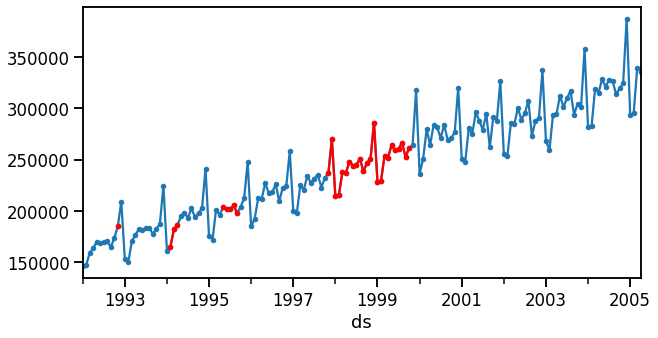

In [10]:
# De-seasonlise original data
df_deseasonalised = df['y'] - seasonal_component

# Perform linear interpolation on de-seasonalised data
df_deseasonalised_imputed = df_deseasonalised.interpolate(method='linear')

# Add seasonal component back to get the final imputed time series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Plot the imputed time series
df_imputed = df_imputed.to_frame().rename(columns={0:'y'})
ax = df_imputed.plot(linestyle='-', marker='.', figsize=[10, 5], legend=None)
ax = df_imputed[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

<AxesSubplot:xlabel='ds'>

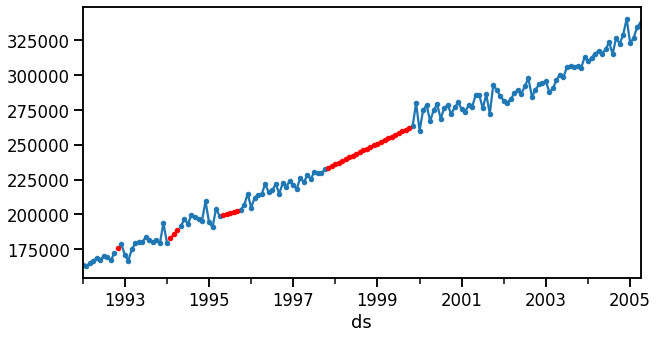

In [11]:
ax = df_deseasonalised.plot(linestyle='-', marker='.', figsize=[10, 5])

df_deseasonalised_imputed.to_frame().rename(
    columns={0:'y'})[df.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

**Note**: 

Simpler seasonal decompositions methods exist in Statsmodels such as `seasonal_decompose`. However, the simplicity of the `seasonal_decompose` method has drawbacks which may or may not be relevant for your use case (e.g., naive seasonal decomposition methods may not capture seasonality which changes over time, may not return values at the start and end of a time series etc.). STL is a more advanced method that is commonly used for data imputation.

# Summary

If your dataset is not strongly seasonal then simple methods such as forward fill or linear interpolation would normally be sufficient. If your data is strongly seasonal and especially if there are large gaps then performing a seasonal decomposition and interpolating the de-seasonalised data is recommended.
